In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from autoemulate.compare import AutoEmulate
from sklearn.metrics import r2_score

from autoemulate.experimental_design import LatinHypercube
from autoemulate.simulations.flow_functions import FlowProblem

show_progress = False if os.getenv("JUPYTER_BOOK_BUILD", "false").lower() == "true" else True

In [ ]:
# Load the simulation input parameters and summary statistics

n_samples = 256

sim_path = f'./outputs/simulations/output_{n_samples}_samples/'

# Load the simulation input parameters
input_params = pd.read_csv(os.path.join(sim_path, f'input_samples_{n_samples}.csv'))

In [9]:
em = AutoEmulate()
parameter_names = list(parameters_range.keys())
em.setup(sample_df[parameter_names], Y, models = ['gp', 'svm','lgbm'])

,Values
Simulation input shape (X),"(60, 9)"
Simulation output shape (y),"(60,)"
Proportion of data for testing (test_set_size),0.2
Scale input data (scale),True
Scaler (scaler),StandardScaler
Scale output data (scale_output),True
Scaler output (scaler_output),StandardScaler
Do hyperparameter search (param_search),False
Reduce input dimensionality (reduce_dim),False
Reduce output dimensionality (reduce_dim_output),False


In [10]:
best_model = em.compare()

Cross-validating:   0%|          | 0/3 [00:00<?, ?it/s]

In [11]:
em.summarise_cv()

,preprocessing,model,short,fold,rmse,r2
0,None,GaussianProcess,gp,2,5.336877,0.995375
1,None,GaussianProcess,gp,1,4.437543,0.994557
2,None,GaussianProcess,gp,4,6.913592,0.993842
3,None,GaussianProcess,gp,0,11.887020,0.975951
4,None,GaussianProcess,gp,3,20.833169,0.898089
5,None,SupportVectorMachines,svm,2,31.133851,0.842592
6,None,SupportVectorMachines,svm,1,23.973295,0.841146
7,None,SupportVectorMachines,svm,4,39.828038,0.795640
8,None,SupportVectorMachines,svm,3,35.767803,0.699603
9,None,SupportVectorMachines,svm,0,43.159782,0.682958


In [12]:
gp = em.get_model("GaussianProcess")
em.evaluate(gp)

,model,short,preprocessing,rmse,r2
0,GaussianProcess,gp,None,7.0284,0.9886


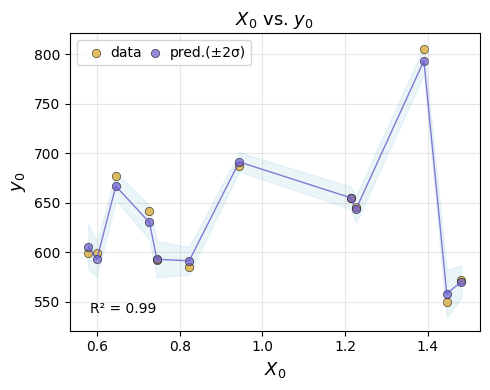

In [13]:
em.plot_eval(gp)

In [14]:
best_emulator = em.refit(gp)

In [15]:
# Extract parameter names and bounds from the dictionary
parameter_names = list(parameters_range.keys())
parameter_bounds = list(parameters_range.values())

# Define the problem dictionary for Sobol sensitivity analysis
problem = {
    'num_vars': len(parameter_names),
    'names': parameter_names,
    'bounds': parameter_bounds
}

In [21]:
em.sensitivity_analysis(problem=problem)

,output,parameter,index,value,confidence
0,y1,T,S1,0.002558,0.000254
1,y1,td,S1,0.021101,0.002438
2,y1,amp,S1,0.889136,0.064112
3,y1,dt,S1,0.000380,0.000050
4,y1,C,S1,0.032391,0.003133
5,y1,R,S1,0.054625,0.004740
6,y1,L,S1,0.002954,0.000303
7,y1,R_o,S1,0.000269,0.000031
8,y1,p_o,S1,0.000456,0.000064
0,y1,T,ST,0.002039,0.004306
